In [224]:
using StatsBase
using Distances
using RDatasets
using Gadfly
using Clustering
using Images
using ImageView
using ProfileView
using Plots

INFO: Precompiling module Plots...


In [56]:
cd("allen_brain/")

In [57]:
vxg_data = readdlm("vxg_data_vsn.csv", ',');

In [65]:
nsubsamples = 5000
nsubfeatures = 50

subsampleinds = sort(sample(1:size(vxg_data)[1], nsubsamples, replace = false))
subfeatureinds = sort(sample(1:size(vxg_data)[2], nsubfeatures, replace = false))

vxg_data_sub = vxg_data[subsampleinds,subfeatureinds];

In [66]:
test_data_sub = vxg_data_sub';
test_data = vxg_data';

![title](minibatch_algorithm.png)

![title](L1_ball_sparsification.png)

In [233]:
"""
    get_cluster_assignments(distance_matrix)

Find the id of the cluster whos center is closest to each sample
size(distance_matrix) = batch_size x n_center (n_center = K)
"""
function get_cluster_assignments!(closest_centers,distance_matrix)
    batch_size,K = size(distance_matrix)
    for sample_i in 1:batch_size
        closest_center_id = 0
        closest_center_dist = Inf
        for center_k in 1:K
            if distance_matrix[sample_i,center_k] < closest_center_dist
                closest_center_dist = distance_matrix[sample_i,center_k]
                closest_centers[sample_i] = center_k
            end
        end
    end
end


"""
    get_objective(distance_mat,cluster_assignments)

Compute the K-means objectove function

∑_x∈X min_c∈C||x-c||^2

i.e. the sum of the squared distances from all points to the closest centroid.

size(distance_matrix) = batch_size x n_center (n_center = K)
size(cluster_assignments) = batch_size
"""
function get_objective(distance_mat,cluster_assignments)
    batch_size,K = size(distance_mat)
    dists_to_closest_center = zeros(batch_size)
    for sample_i = 1:batch_size
        dists_to_closest_center[sample_i] = distance_mat[sample_i,cluster_assignments[sample_i]]
    end
    obj = sum(dists_to_closest_center)
    return obj
end


"""
    update_centers(Mt,Ct,d,v)

optimized update of centers for minbatches

inputs:
    Mt: transpose of minibatch dataset
    Ct: centers to update
    d: current cluster assignments
    v: cumulative count vector for center membership (over all minibatches)

size(Mt) = n_features x batch_size
size(Ct) = n_features x K
size(d) = K
size(v) = K
"""
function update_centers!(M,C,d,v)

    n_features,batch_size = size(M)
    K = size(C,2)
    
    for sample_j in 1:batch_size
        x = view(M,:,sample_j)
        c = d[sample_j]
        Cc = view(C,:,c)
        v[c] += 1.0
        @fastmath η = 1.0/v[c]
        @inbounds @fastmath for feature_i = 1:n_features
            Cc[feature_i] += η*(x[feature_i] - Cc[feature_i])
        end
    end
end


"""
    kmpp(X,K)

size(X) = n_samples x n_features
K = n_centers

Initialize cetroids using kmeans++ algorithm,
returning indices of points to be used as initial centroids
"""
function kmpp(X,K)
    n_features,n_samples = size(X)
    all_center_inds = 1:n_samples
    my_center_inds = sample(1:n_samples,1)
    closest_center_dists = zeros(n_samples)
    closest_centers = zeros(Int64,n_samples)
    
    for k = 2:K
        C = X[:,my_center_inds]
        pdists = pairwise(SqEuclidean(), X, C)
        get_cluster_assignments!(closest_centers,pdists)
        for sample_j = 1:n_samples
            closest_center_dists[sample_j] = pdists[sample_j,closest_centers[sample_j]]
        end
        new_center_ind = wsample(all_center_inds,closest_center_dists,1)
        append!(my_center_inds, new_center_ind)
    end
    return(my_center_inds)
end

"""
    km_random_init(X,K)

size(X) = n_features x n_samples
K = n_centers

Initialize cetroids using random sampling (dumb but fast)
returning indices of points to be used as initial centroids
"""
function km_random_init(X,K)
    nsamples,nfeatures = size(X)
    C = sample(1:nsamples, K, replace = false)
    return(C)
end

"""
    get_minibatch!(M,X,sample_inds)

size(X) = n_features x n_samples
length(sample_inds) = batch_size
size(M) = n_features x batch_size
"""
function get_minibatch!(M::Array{Float64,2},X::Array{Float64,2},sample_inds::Array{Int64,1})
#     @inbounds Mt = slice(Xt,:,sample_inds)
#     @inbounds Mt = Xt[:,sample_inds]
#     @inbounds Mt = sub(Xt,:,sample_inds)
#     M[:] = X[:,sample_inds]
    
    nfeatures,batch_size = size(M)
    @inbounds for i_sample = 1:batch_size
        @inbounds for j_feature = 1:nfeatures
            M[j_feature,i_sample] = X[j_feature,sample_inds[i_sample]]
        end
    end
    
end


"""
    get_sample_inds!(sample_inds, batch_size, totsamples)

update sample_inds with a new random sample
"""
function get_sample_inds!(sample_inds::Array{Int64,1},batch_size::Int64,totsamples::Int64)
    sample_inds[:] = sample(1:totsamples, batch_size, replace = false)
#     sample_inds = sort(sample(1:nsamples, batch_size, replace = false))
    return
end

"""
    verbose_info(verbose,X,C,t;interval=100)

print out info if verbose is true
"""
function verbose_info(verbose,X,C,d_tot,t;interval=100)
    if verbose == true
        if t % interval == 0
            tot_distance_matrix = pairwise(SqEuclidean(), X,C)
            get_cluster_assignments!(d_tot,tot_distance_matrix)
            objective = get_objective(tot_distance_matrix,d_tot)
            println("iteration = ",t)
            println("objective = ",objective)
        end
    end
end


"""
    pdist!(P,A,B)

reference pairwise distace function

P: pairwise distance matrix to be filled in
A: ndims x nsamplesA matrix ie columns are samples
B: ndims x nsamplesB matrix ie columns are samples
"""
function pdist!(P,A,B)
    dA,nA = size(A)
    dB,nB = size(B)
    @inbounds for a=1:nA
        @inbounds for b=1:nB
            @inbounds for d=1:dA
                P[a,b] += (A[d,a] - B[d,b])^2
            end
        end
    end
end


"""
    L1_projection!(c,λ,ϵ)

c: vector to sparsify
λ: sparsification threshold (bigger is less sparse)
ϵ: convergence tolerence (bigger is less strict but faster)
"""
function L1_projection!(c,λ)
    ϵ = 1e-6    
    if norm(c,1) <= λ + ϵ
        return
    end
    upper = norm(c,Inf)
    lower = 0.0
    current = norm(c,1)
    θ = 0.0
    while (current > λ*(1.0 + ϵ)) || (current < λ)
        θ = (upper + lower)/2.0
        current = sum([max(0, abs(ci) - θ) for ci in c[c.!=0]])
        if current <= λ
            upper = θ
        else
            lower = θ
        end
    end
    for i = 1:length(c)
        c[i] = sign(c[i])*max(0,abs(c[i]) - θ)
    end
end

function L1_projection_allcenters!(C,λ)
    nfeatures,ncenters = size(C)
    for i = 1:ncenters
        c = view(C,:,i)
        L1_projection!(c,λ)
    end
end

"""
    L1_projection_joint!(C,λ)

Work with all the center vectors at once.  project each based on a consunsus.
"""
function L1_projection_joint!(C,λ)
    ϵ = 1e-6    
    
    ndims,ncenters = size(C)
    Cm = vec(mean(abs(some_centers),2))
    
    if norm(Cm,1) <= λ + ϵ
        return
    end
    upper = norm(Cm,Inf)
    lower = 0.0
    current = norm(Cm,1)
    θ = 0.0
    while (current > λ*(1.0 + ϵ)) || (current < λ)
        θ = (upper + lower)/2.0
        current = sum([max(0, abs(Cm_i) - θ) for Cm_i in Cm[Cm.!=0]])
        if current <= λ
            upper = θ
        else
            lower = θ
        end
    end
    for i = 1:ncenters
        C[:,i] = sign(C[:,i]).*map(x -> max(0,x-θ), C[:,i])
    end
end

L1_projection_joint! (generic function with 1 method)

In [258]:
some_centers = randn(50,12);
L1_projection_joint!(some_centers,0.00001)
nonzero_features = mean(sum(some_centers,2) .!= 0.0)
@show nonzero_features
print(sum(some_centers,2))

nonzero_features = 0.74
[0.0
 0.0
 0.08689702062700544
 0.7226467176375055
 0.9200673606072558
 0.3986769617777546
 0.0
 0.2557981064772583
 0.3841595422518309
 0.1835325273777535
 1.471978086618117
 0.0
 0.02457174888529745
 0.34658531292896555
 0.4114099157933042
 0.36845581270891836
 0.0
 0.12911526193687628
 0.0
 0.0
 0.0
 1.8778603119232988
 0.05792032184965645
 0.1698312040985226
 0.39883120132806127
 0.0
 1.345918205242528
 1.5594855691006115
 0.4243960218479099
 0.3941715513960302
 0.29899054574595985
 0.6806811926600143
 1.17452089329759
 0.6966950464977555
 1.7852899598438832
 1.878178599399797
 3.149212746446059
 0.0
 0.0
 0.0
 0.8549040570847621
 0.7649969575983397
 0.0
 0.3121539143867471
 1.1449294741115987
 1.415462903281143
 0.4737492715091418
 0.21115777321358187
 0.5846380416929464
 0.7329312118573565]

In [106]:
# size(X) = nfeatures x nsamples -- julia is column-major ordered,
# so each column is a sample. THIS IS THE OPPOSITE OF R OR PYTHON.

function minibatch_kmeans(X::Array{Float64,2}, K::Int64; batch_size=10::Int64, max_iters::Int64 = 1000, init::AbstractString="kmpp", λ=Inf, verbose::Bool = false)
    
    nfeatures,nsamples = size(X)

    # pre-allocate empty arrays
    C = zeros(Float64,nfeatures,K)
    sample_inds = zeros(Int64,batch_size)
    M = zeros(Float64,nfeatures,batch_size)
    distance_matrix = zeros(Float64,batch_size,K)
    d = zeros(Int64,batch_size)
    d_tot = zeros(Int64,nsamples)
    x = zeros(nfeatures)
    v = zeros(Float64,K)
    c = 0
    η = 0.0
        
    # initialize the centers
    if init == "kmpp"
        initial_center_inds = kmpp(X,K)
    else
        initial_center_inds = km_random_init(X,K)
    end

    C[:] = X[:,initial_center_inds]
    
    # main k-means loop
    delta = nsamples
    converged = false
    t = 1
    while !converged && t <= max_iters
    
        # get a new mini-batch sample of the data
        get_sample_inds!(sample_inds,batch_size,nsamples)

        get_minibatch!(M,X,sample_inds)

        # compute the pairwise distances between every center and centroid
        pairwise!(distance_matrix,SqEuclidean(), M, C)

        # get assignments of every point in the minibatch
        get_cluster_assignments!(d,distance_matrix)
        
        # update the master list of cluster memberships
        d_tot_old = d_tot[:]
        for i in 1:batch_size
            d_tot[sample_inds[i]] = d[i]
        end
        
        # see how much we changed
        delta_old = copy(delta)
        delta = sum(d_tot_old .!= d_tot)
        
        # stop early if cluster memberships don't change for two iterations in a row
        converged = (delta == 0) && (delta_old == 0)
#         converged = false
        
        # for each point in the minibatch, use its location to update the 
        # position of the closest centroid. Ct gets updated in place
        update_centers!(M,C,d,v)
        
        # project the centers to a sparse subset of features
        # each center gets projected to a different subset :(
        L1_projection_joint!(C,λ)
        
        # print out convergence info if the occasion warrants
        verbose_info(verbose,X,C,copy(d_tot),t;interval=100)
        
        # update counter
        t += 1

    end
    println(t-1," iterations performed")
    tot_distance_matrix = pairwise(SqEuclidean(), X, C)
    return(get_cluster_assignments!(copy(d_tot),tot_distance_matrix))
end

minibatch_kmeans (generic function with 1 method)

In [122]:
@time minibatch_kmeans(test_data, 12, batch_size=50, max_iters=1000, init="kmpp", λ=Inf, verbose=true)

iteration = 100
objective = 3.16455461177257e8
iteration = 200
objective = 3.1434720850314885e8
iteration = 300
objective = 3.1381237643160284e8
iteration = 400
objective = 3.135583577036493e8
iteration = 500
objective = 3.133773186918063e8
iteration = 600
objective = 3.132252341661098e8
iteration = 700
objective = 3.130907403222218e8
iteration = 800
objective = 3.1296964882958686e8
iteration = 900
objective = 3.129061734974234e8
iteration = 1000
objective = 3.128377042533715e8
1000 iterations performed
 10.773694 seconds (185.15 k allocations: 872.934 MB, 0.91% gc time)


In [328]:
ndim = 5000
ntot = 50000
nsamp = 500
nK = 12

X = randn(ndim,ntot)
M = zeros(ndim,nsamp)
S = sample(1:ntot,nsamp,replace=false);
C = X[:,sample(1:ntot,nK,replace=false)]
P = zeros(nsamp,nK);

In [321]:
function check_pdist(P, M, C)
    for i=1:1000
        pdist!(P, M, C);
    end
end
check_pdist(P, M, C)

In [322]:
@time check_pdist(P, M, C)

 27.991447 seconds (4 allocations: 160 bytes)


In [348]:
function check_pairwise(P, M, C)
    for i=1:10
        pairwise!(P, SqEuclidean(), M, C);
    end
end
check_pairwise(P, M, C)

In [349]:
@time check_pairwise(P, M, C)

  0.065268 seconds (144 allocations: 46.875 KB)


In [331]:
@allocated zeros(nsamp,nK)

48144

In [305]:
Profile.init(delay=0.1)
Profile.clear()
@profile minibatch_kmeans(test_data, 12, batch_size=500, max_iters=1000, init="random", verbose=false);

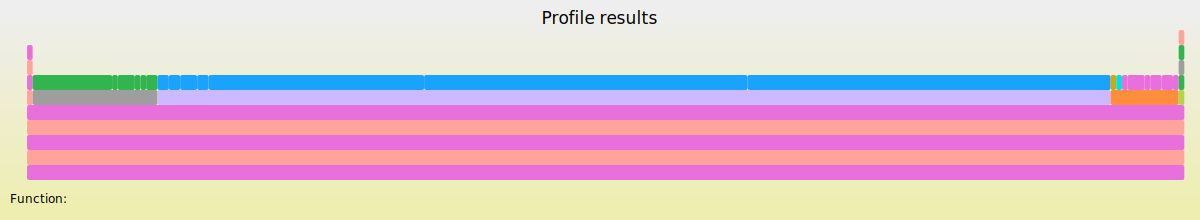

In [246]:
ProfileView.view()

In [ ]:
Profile.

In [239]:
function kmeans_lloyd(X, k; max_iters = 1000, verbose = false)
    
    # initialize the centers
    initial_center_inds = kmpp(X,k)
    C = X[initial_center_inds,:]
    
    t = 1
    delta = Inf
    objective = Inf
    
    while (delta != 0) && (t <= max_iters)
        distance_matrix = pairwise(SqEuclidean(), X',C')
        d = get_cluster_assignments(distance_matrix)

        for i = 1:k
            C[i,:] = mean(X[d .== i,:],1)
        end


        ojective_old = objective
        objective = get_objective(distance_matrix,d)
        delta = ojective_old - objective
        
        if verbose
            if t % 1 == 0
                @show t,delta,objective
            end
        end
        t += 1
    end
    return(get_cluster_assignments(pairwise(SqEuclidean(), X',C')))
end

kmeans_lloyd (generic function with 1 method)

In [ ]:
kmout_ref = kmeans(vxg_data', 12; maxiter=200, display=:iter);

In [240]:
kmout_lloyd = kmeans_lloyd(vxg_data,12, verbose = true)

(t,delta,objective) = (1,Inf,5.644695236420434e8)
(t,delta,objective) = (2,2.373036957121312e8,3.2716582792991215e8)
(t,delta,objective) = (3,1.0212771558272481e7,3.1695305637163967e8)
(t,delta,objective) = (4,4.008932006634295e6,3.129441243650054e8)
(t,delta,objective) = (5,1.6114367854710817e6,3.113326875795343e8)
(t,delta,objective) = (6,1.0257444294553995e6,3.103069431500789e8)
(t,delta,objective) = (7,812573.214265883,3.09494369935813e8)
(t,delta,objective) = (8,618913.9301219583,3.0887545600569105e8)
(t,delta,objective) = (9,448926.3946570754,3.08426529611034e8)
(t,delta,objective) = (10,241107.066765666,3.081854225442683e8)
(t,delta,objective) = (11,152684.30269038677,3.080327382415779e8)
(t,delta,objective) = (12,97053.53776162863,3.079356847038163e8)
(t,delta,objective) = (13,63537.23907017708,3.078721474647461e8)
(t,delta,objective) = (14,44524.30959671736,3.078276231551494e8)
(t,delta,objective) = (15,29560.602398455143,3.0779806255275095e8)
(t,delta,objective) = (16,25950.7

49742-element Array{Int64,1}:
 6
 6
 6
 6
 6
 6
 6
 6
 6
 6
 6
 6
 6
 ⋮
 9
 9
 9
 9
 9
 9
 9
 9
 9
 9
 7
 7

In [241]:
hist(kmout_lloyd)

(0.0:1.0:12.0,[5308,913,1665,7521,5040,5249,3363,3441,7417,1576,3897,4352])

In [ ]:
vxg_df_sub = DataFrame(vxg_data_sub);
vxg_df = DataFrame(vxg_data);

In [ ]:
myplot = plot(vxg_df, x = "x1", y = "x2", color = [string(i) for i in kmout.assignments], Geom.point);
draw(PNG("plot.png", 10inch, 6inch), myplot)
img = load("plot.png")

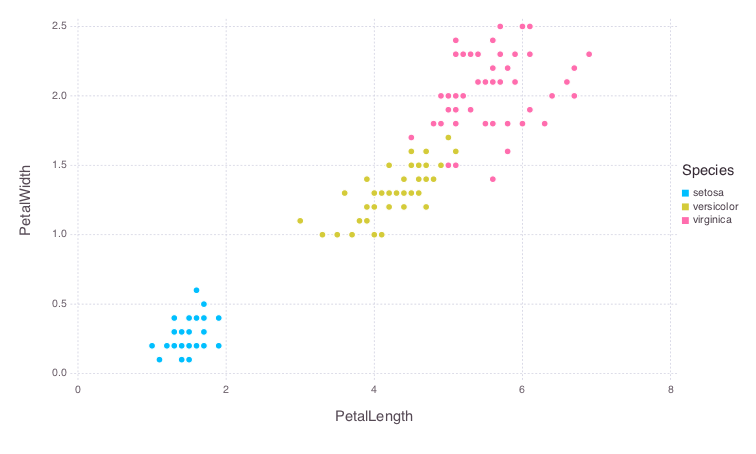

In [286]:
iris = dataset("datasets", "iris")
set_default_plot_size(20cm, 12cm)
plot(iris, x = "PetalLength", y = "PetalWidth", color = "Species", Geom.point)

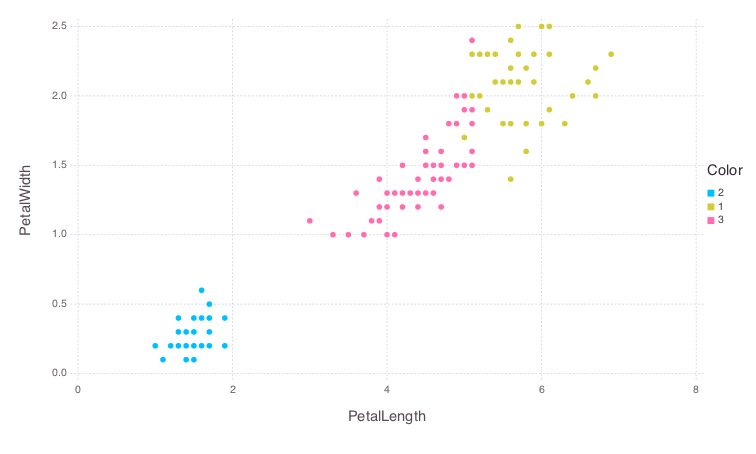

In [285]:
features = array(iris[:, 1:4])'
result = kmeans( features, 3 )
plot(iris, x = "PetalLength", y = "PetalWidth", color = [string(i) for i in result.assignments], Geom.point)

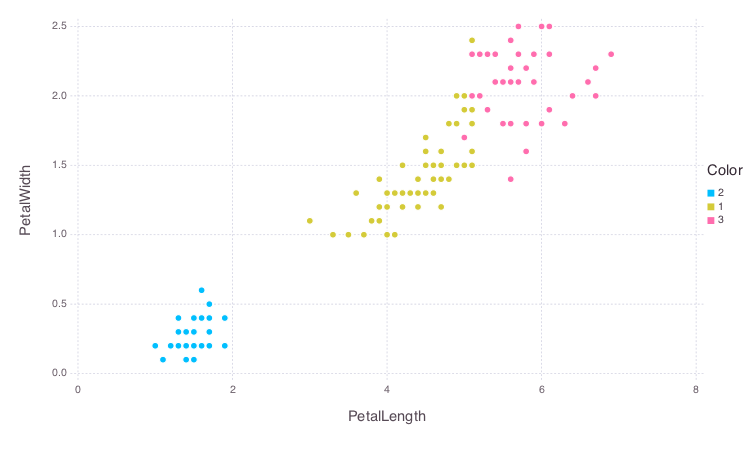

In [284]:
kmout_lloyd_iris = kmeans_lloyd(features', 3)
plot(iris, x = "PetalLength", y = "PetalWidth", color = [string(i) for i in kmout_lloyd_iris], Geom.point)

(nfeatures,nsamples) = (4,150)
"" = ""
t = 100
tot_objective = 83.92838952203948
"" = ""
t = 200
tot_objective = 83.12725258982805
"" = ""
t = 300
tot_objective = 82.29917670483532
"" = ""
t = 400
tot_objective = 82.02819675959245
"" = ""
t = 500
tot_objective = 81.90336531103756
"" = ""
t = 600
tot_objective = 81.72886683097862
"" = ""
t = 700
tot_objective = 81.42818377711198
"" = ""
t = 800
tot_objective = 81.37637586989835
"" = ""
t = 900
tot_objective = 81.15337358353933
"" = ""
t = 1000
tot_objective = 80.99095683863531


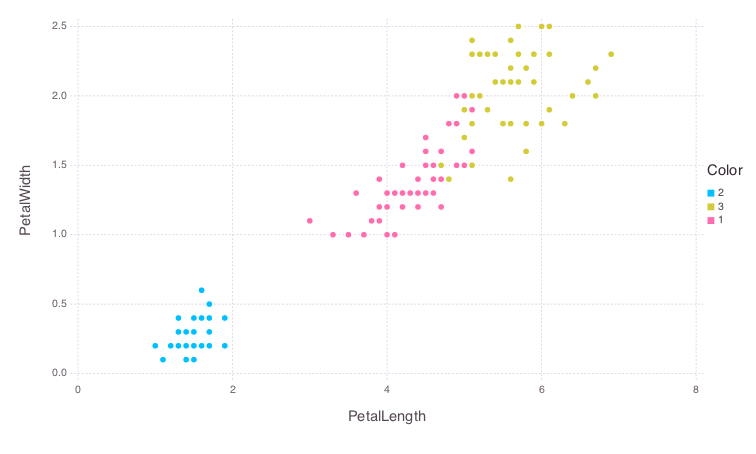

In [297]:
kmout_mb_iris = minibatch_kmeans(features, 3, batch_size=5, max_iters=1000, verbose=true)
plot(iris, x = "PetalLength", y = "PetalWidth", color = [string(i) for i in kmout_mb_iris], Geom.point)

In [192]:
A = reshape(1:15,5,3)
a = sub(A,:,3)
# for i = 1:5
#     a[i] += 100
# end
a += 222
A

5x3 Array{Int64,2}:
 1   6  11
 2   7  12
 3   8  13
 4   9  14
 5  10  15

In [147]:
function update_centers_test!(Mt,Ct)
#     @show Ct
    n_features,batch_size = size(Mt)
    
    k = size(Ct,2)
    for j in 1:batch_size
        x = view(Mt,:,j)
        Ctc = view(Ct,:,sample(1:k))
        η = 1.0/rand(2.0:10.0)
        for i = 1:n_features
            Ctc[i] += η*(x[i] - Ctc[i])
        end
    end
#     @show Ct
end

update_centers_test! (generic function with 1 method)

In [151]:
C_trans = randn(3,4)
println(C_trans)
M_trans = randn(3,100)
update_centers_test!(M_trans,C_trans);
println(C_trans)

[-0.1582129991514024 -1.3843204583893516 0.7110994891817933 -0.8313544851248851
 -0.8662635650559638 3.035613328180735 1.4706530773608075 -0.20847357238289352
 -0.40224888356201133 -1.0282409388161426 -0.35056658743437846 0.598614419161152]
[-0.2681707583004023 -0.4178403041086928 -0.19848420666872602 0.08626142897365323
 0.46460323094431843 0.3714425459547117 0.10266625550812655 0.2499182408251813
 -0.3002181668275561 0.2695123273348667 -0.23168194125024638 0.6504848612334309]


In [232]:
function test_subsetting(X; batch_size=500, nloops=100)
    nfeatures, nsamples = size(X)
    ref_samples = X[:,1:10]
    batch_inds = zeros(batch_size)
    batch = zeros(nfeatures,batch_size)
    d_matrix = zeros(batch_size,batch_size)
    for i = 1:nloops
        batch_inds = sort(sample(1:nsamples, batch_size, replace = false))
        batch = X[:,batch_inds]
        d_matrix = pairwise(SqEuclidean(), batch, ref_samples)
    end
end

test_subsetting (generic function with 3 methods)

In [233]:
X_test = randn(5000,50000);

Profile.init(delay=0.1)
test_subsetting(X_test, batch_size=500, nloops=1000);
Profile.clear()
@profile test_subsetting(X_test, batch_size=500, nloops=1000);

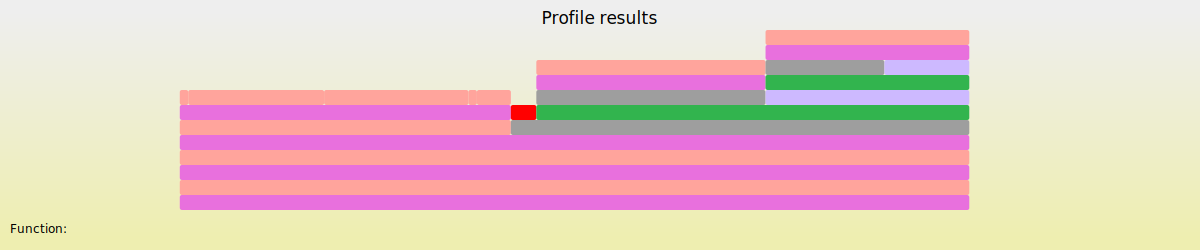

In [234]:
ProfileView.view()

In [237]:
Profile.print()

94 task.jl; anonymous; line: 447
 94 ...4/IJulia/src/IJulia.jl; eventloop; line: 143
  94 ...rc/execute_request.jl; execute_request_0x535c5df2; line: 183
   94 loading.jl; include_string; line: 282
    1  In[232]; test_subsetting; line: 9
     1 multidimensional.jl; _getindex; line: 186
      1 multidimensional.jl; _unsafe_getindex; line: 195
    93 profile.jl; anonymous; line: 16
     39 In[232]; test_subsetting; line: 9
      39 multidimensional.jl; _getindex; line: 186
       39 multidimensional.jl; _unsafe_getindex; line: 195
     54 In[232]; test_subsetting; line: 10
      3  ...ances/src/generic.jl; pairwise; line: 120
      51 ...ances/src/generic.jl; pairwise; line: 121
       27 ...nces/src/metrics.jl; pairwise!; line: 225
        27 linalg/matmul.jl; gemm_wrapper!; line: 329
         27 linalg/blas.jl; gemm!; line: 633
       24 ...nces/src/metrics.jl; pairwise!; line: 226
        24 reducedim.jl; _mapreducedim!; line: 197
         14 reduce.jl; mapreduce_pairwise_impl; line:

In [238]:
@time test_subsetting(X_test, batch_size=500, nloops=1000);

 14.301897 seconds (51.02 k allocations: 18.720 GB, 14.25% gc time)


In [305]:
c = 0
typeof(c)

Int64

In [306]:
sample_inds = sort(sample(1:100, 10, replace = false))

10-element Array{Int64,1}:
  1
  6
 29
 31
 40
 53
 67
 74
 85
 92

In [24]:
foo = randn(100,300)
bar = randn(100,400)
baz = randn(300,400)
pairwise!(baz,SqEuclidean(),foo,bar);

In [267]:
function subsample1!(M,X,S)
    M = X[:,S]
end

function subsample2!(M,X,S)
    M[:] = X[:,S]
end

function subsample3!(M,X,S)
    ndim,nsamp = size(M)
    for i = 1:nsamp
        for j = 1:ndim
            M[j,i] = X[j,S[i]]
        end
    end
end

function subsample4!(M,X,S)
    ndim,nsamp = size(M)
    @inbounds for i = 1:nsamp
        @inbounds for j = 1:ndim
            M[j,i] = X[j,S[i]]
        end
    end
end

function test_subsampling(subsamplefunction,M,X,S;nloops=100)
    for i=1:nloops
        subsamplefunction(M,X,S)
    end
end

test_subsampling (generic function with 1 method)

In [222]:
ndim = 5000
ntot = 50000
nsamp = 500

X = randn(ndim,50000)
M = zeros(ndim,nsamp)
S = sample(1:50000,nsamp,replace=false);

In [225]:
@time test_subsampling(subsample1,X,M,S);

  0.548578 seconds (404 allocations: 1.863 GB, 28.73% gc time)


In [227]:
@time test_subsampling(subsample2,X,M,S);

  0.755094 seconds (404 allocations: 1.863 GB, 22.73% gc time)


In [229]:
@time test_subsampling(subsample3,X,M,S);

  0.367863 seconds (4 allocations: 160 bytes)


In [269]:
@time test_subsampling(subsample4,X,M,S);

  0.225801 seconds (4 allocations: 160 bytes)


In [266]:
test_subsampling(subsample4,X,M,S)

20976

In [356]:
typeof("foo")

ASCIIString

In [152]:
X = rand(500,1000)
S = sample(1:1000,100,replace=false)
M = view(X,:,1:100)
C = randn(500,25)
pairwise(SqEuclidean(),M,C)

LoadError: LoadError: MethodError: `view` has no method matching view(::Array{Float64,2}, ::Colon, ::Array{Int64,1})
Closest candidates are:
  view(::DenseArray{T,N}, ::Union{Colon,Range{T},Real})
  view(::DenseArray{T,N}, ::Union{Colon,Range{T},Real}, !Matched::Union{Colon,Range{T},Real})
  view(::DenseArray{T,N}, ::Union{Colon,Range{T},Real}, !Matched::Union{Colon,Range{T},Real}, !Matched::Union{Colon,Range{T},Real})
  ...
while loading In[152], in expression starting on line 3

In [164]:
X = rand(500,1000)
S = sample(1:1000,500,replace=false)
Stup = tuple(S...)
M = sub(X,:,Stup)
M2 = sub(X,:,1:500)
C = randn(500,25)
pairwise(SqEuclidean(),M,M)

LoadError: LoadError: MethodError: `sub` has no method matching sub(::Array{Float64,2}, ::Colon, ::Tuple{Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64})
Closest candidates are:
  sub(::AbstractArray{T,N}, !Matched::Union{AbstractArray{T,1},Colon,Int64}...)
  sub(!Matched::DataFrames.AbstractDataFrame, ::Any, ::Any)
  sub(!Matched::Images.AbstractImage{T,N}, !Matched::Union{AbstractArray{T<:Real,1},Colon,Int64}...)
  ...
while loading In[164], in expression starting on line 4

In [166]:
M2 = sub(X,:,1:500)
typeof(M2)

SubArray{Float64,2,Array{Float64,2},Tuple{Colon,UnitRange{Int64}},2}

In [165]:
M = sub(X,:,Stup)
typeof(M)

LoadError: LoadError: MethodError: `sub` has no method matching sub(::Array{Float64,2}, ::Colon, ::Tuple{Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64})
Closest candidates are:
  sub(::AbstractArray{T,N}, !Matched::Union{AbstractArray{T,1},Colon,Int64}...)
  sub(!Matched::DataFrames.AbstractDataFrame, ::Any, ::Any)
  sub(!Matched::Images.AbstractImage{T,N}, !Matched::Union{AbstractArray{T<:Real,1},Colon,Int64}...)
  ...
while loading In[165], in expression starting on line 1

In [153]:
typeof(1:10)

UnitRange{Int64}